In [1]:
from google.colab import drive
drive.mount('/content/drive')
#google drive dosyalarimiza erisebilmek icin drive'imizi calisma ortamimiza dahil ediyoruz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [3]:
ls -al /content/drive/MyDrive/dataset

total 8
drwx------ 2 root root 4096 Mar 15 20:55 COVID/
drwx------ 2 root root 4096 Mar 15 20:55 non-COVID/


In [4]:
imagePaths = "/content/drive/MyDrive/dataset"

In [5]:
batch_size=32
img_height = 255
img_width = 255

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 496 files for validation.


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 255, 255, 3)
(32,)


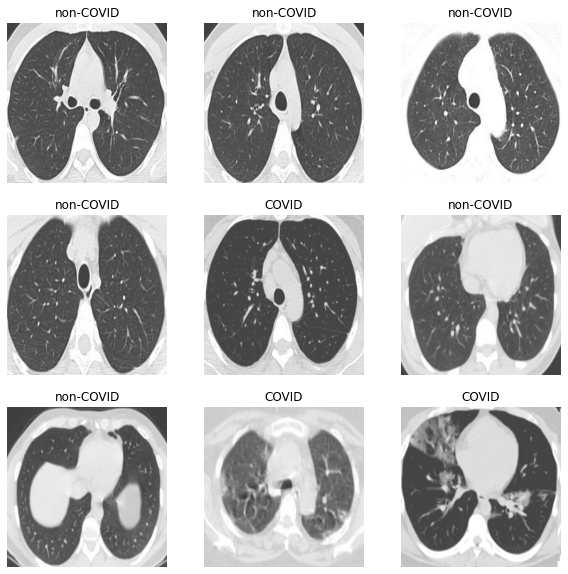

In [8]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.22350238 1.0


In [10]:
model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255),
        Conv2D(32, 3, activation='relu', name='conv_1', padding='SAME'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu',padding='SAME', name='conv_2'),
        MaxPooling2D(pool_size=(8, 8), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=16, activation='relu', name='dense_1'),
        Dense(units=2, activation='softmax', name='dense_2')
    ])

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [13]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    #return early_stopping

In [14]:
def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_best_path= 'checkpoints_best_only/checkpoint'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=True,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [15]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=callbacks)

Epoch 1/3
63/63 [==============================] - 220s 3s/step - loss: 0.5919 - accuracy: 0.6967 - val_loss: 0.8269 - val_accuracy: 0.5464

Epoch 00001: val_accuracy improved from -inf to 0.54637, saving model to checkpoints_best_only/checkpoint
Epoch 2/3
63/63 [==============================] - 218s 3s/step - loss: 0.5911 - accuracy: 0.6902 - val_loss: 0.5341 - val_accuracy: 0.7157

Epoch 00002: val_accuracy improved from 0.54637 to 0.71573, saving model to checkpoints_best_only/checkpoint
Epoch 3/3
63/63 [==============================] - 225s 4s/step - loss: 0.4779 - accuracy: 0.7763 - val_loss: 0.4814 - val_accuracy: 0.7601

Epoch 00003: val_accuracy improved from 0.71573 to 0.76008, saving model to checkpoints_best_only/checkpoint


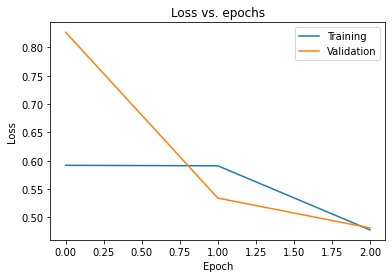

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

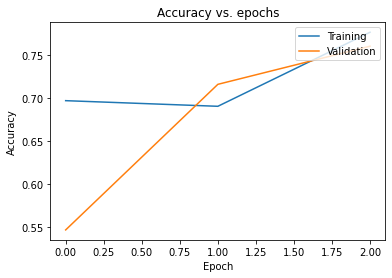

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()